In [1]:
# Required libraries
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

In [2]:
def cir_em(T, n_steps, n_paths, kappa, theta, sigma, dW):
    """
    Generates CIR process using the Euler-Maruyama method.
    
    Parameters:
    T : float
        Time period.
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of paths.
    kappa : float
        Mean reversion rate.
    theta : float
        Long-term mean.
    sigma : float
        Volatility parameter.
    dW : ndarray
        Brownian motion increments.

    Returns:
    ndarray
        Simulated CIR paths.
    """
    r_paths = np.ones((n_paths, n_steps+1))
    r_paths[:,0] = theta
    
    # Generate the CIR process using the Eurler-Maryuma explicit method
    for i in range(n_steps):
        r_paths[:, i+1] = r_paths[:,i] + (kappa * (theta - r_paths[:,i]) * T) + np.sqrt(r_paths[:,i]) * sigma * dW[:,i]
    return r_paths

# Simulate asset prices using geometric Brownian motions and Euler method
def simulate_gbm(mu, sigma, T, n_steps, n_paths, s0, dW):
    """
    Simulates asset prices using the geometric Brownian motion model.

    Parameters:
    mu : float
        Drift term.
    sigma : ndarray
        Volatility (can be time-varying).
    T : float
        Time period.
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of paths.
    s0 : float
        Initial asset price.
    dW : ndarray
        Brownian motion increments.

    Returns:
    ndarray
        Simulated asset price paths.
    """
    # Initialize the parameters
    s_paths = np.zeros((n_paths, n_steps+1))
    s_paths[:,0] = s0

    # Generate asset price process using correlated Brownian motions
    for i in range(n_steps):
        s_paths[:, i+1] = s_paths[:,i] + (mu * s_paths[:,i] * T) + (sigma[:,i] * s_paths[:,i] * dW[:,i])
    
    return s_paths

def call_option_price(S, K, r, q, T, sigma):
    """
    Calculates the call option prices and deltas using the Black-Scholes formula.

    Parameters:
    S : float
        Current asset price.
    K : float
        Strike price.
    r : float
        Risk-free interest rate.
    q : float
        Dividend yield.
    T : float
        Time to maturity.
    sigma : float
        Volatility of the underlying asset.

    Returns:
    tuple
        Call option prices and deltas.
    """
    d1 = (np.log(S / K) + (r - q + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    call_delta = stats.norm.cdf(d1)
    return call_price, call_delta

def call_option_delta_hedge_process(number_of_shares, hedging_frequency, risk_free_rate, s_paths, option_prices, option_deltas, n_steps, n_paths):
    """
    Simulates the delta hedge process for a portfolio of call options.

    Parameters:
    number_of_shares : int
        Number of shares.
    hedging_frequency : float
        Frequency of hedging.
    risk_free_rate : float
        Risk-free interest rate.
    s_paths : ndarray
        Simulated asset price paths.
    option_prices : ndarray
        Call option prices.
    option_deltas : ndarray
        Call option deltas.
    n_steps : int
        Number of time steps.
    n_paths : int
        Number of paths.

    Returns:
    tuple
        Portfolio value and hedge interest.
    """
    value = np.zeros((n_paths, n_steps+1))
    value[:,0] = option_prices[:,0] * number_of_shares
    hedge_interest = np.zeros((n_paths, n_steps+1))
    hedge_interest[:,0] = value[:,0] - number_of_shares * option_deltas[:,0] * s_paths[:,0]

    # Delta hedge process
    for i in range(n_steps):
        value[:,i + 1] = value[:,i] + (option_deltas[:,i] * (s_paths[:,i + 1] - s_paths[:,i])) + \
            hedge_interest[:,i] * (np.exp((hedging_frequency / n_steps) * risk_free_rate) - 1)
        hedge_interest[:,i + 1] = value[:,i + 1] - option_deltas[:,i + 1] * s_paths[:,i + 1]

    return value, hedge_interest

def calc_prop_above_below_rt_s_paths_portfolio(s_paths_gbm, K_threshold, R_t):
    """
    Calculate proportions of paths above and below a given threshold relative to a reference value.

    This function computes the proportions of paths in a geometric Brownian motion (GBM) model
    that remain either above or below a specified threshold relative to a reference value (R_t).

    Inputs:
    - s_paths_gbm: Array of simulated asset price paths (GBM) over time.
    - K_threshold: Array of threshold values relative to R_t.
    - R_t: Reference value used for threshold computation.

    Outputs:
    - prop_below_rt: Array of proportions of paths below the threshold for each K_threshold value.
    - prop_above_rt: Array of proportions of paths above the threshold for each K_threshold value.
    """
        
    # Initialize arrays to store proportions
    prop_above_rt = np.zeros(len(K_threshold))
    prop_below_rt = np.zeros(len(K_threshold))
    
    # Calculate the mask once outside the loop to avoid repeated computation
    log_s_paths_gbm = np.log1p(s_paths_gbm)
    
    for i in range(len(K_threshold)):
        # Compute the threshold for the current K_threshold value
        threshold = R_t - K_threshold[i]
        
        # Create a mask indicating whether each path is above the threshold
        above_rt_mask = log_s_paths_gbm > threshold
        
        # Check if each path remains above the threshold for all time steps
        path_complete_mask = np.all(above_rt_mask[:, :-1], axis=1)
        
        # Calculate proportion of paths above and below the threshold
        prop_above_rt[i] = np.mean(path_complete_mask)
        prop_below_rt[i] = 1 - prop_above_rt[i]  # All paths sum to 1
        
    return prop_below_rt, prop_above_rt

def buy_hold_portfolio_payoff_T(s, s0, r, T):
    """
    Calculate the payoff of a buy-and-hold portfolio at time T.

    Parameters:
    s : ndarray
        Simulated asset prices at each time step for multiple paths.
    s0 : float
        Initial asset price.
    r : float
        Risk-free rate.
    T : floatTotal time horizon.

    Returns:
        ndarray: Payoff of the buy-and-hold portfolio at time T for each path.
    """
    return s[:, -1] - s0 * np.exp(r * T)


def buy_hold_portfolio_payoff_T_2(s, s0, r, T, n_steps):
    """
    Calculate the payoff of a buy-and-hold portfolio at half of the total time horizon.

    Parameters:
    s : ndarray
        Simulated asset prices at each time step for multiple paths.
    s0 : float 
        Initial asset price.
    r : float
        Risk-free rate.
    T : float 
        Total time horizon.
    n_steps : int
        Number of time steps.

    Returns:
        ndarray: Payoff of the buy-and-hold portfolio at half of the total time horizon for each path.
    """
    return s[:, n_steps // 2] - s0 * np.exp(r * T / 2)


def long_call_portfolio_payoff_T(hedged_p, call_p, r, t):
    """
    Calculate the payoff of a long call portfolio at time t.

    Parameters:
    hedged_p : ndarray
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray
        Call option prices at each time step for multiple paths.
    r : float
        Risk-free rate.
    t : float
        Time horizon.

    Returns:
        ndarray: Payoff of the long call portfolio at time t for each path.
    """
    return hedged_p[:, -1] - call_p[:, 1] * np.exp(r * t)


def long_call_portfolio_payoff_T_2(hedged_p, call_p, r, t, n_steps):
    """
    Calculate the payoff of a long call portfolio at half of the total time horizon.

    Parameters:
    hedged_p : ndarray
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray 
        Call option prices at each time step for multiple paths.
    r : float
        Risk-free rate.
    t float
        Total time horizon.
    n_steps : int
        Number of time steps.

    Returns:
        ndarray: Payoff of the long call portfolio at half of the total time horizon for each path.
    """
    return hedged_p[:, n_steps // 2] - call_p[:, 1] * np.exp(r * t / 2)


def short_call_portfolio_payoff_T(hedged_p, call_p, t):
    """
    Calculate the payoff of a short call portfolio at time t.

    Parameters:
    hedged_p : ndarray 
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray
        Call option prices at each time step for multiple paths.
    t : int
        Time step index.

    Returns:
        ndarray: Payoff of the short call portfolio at time t for each path.
    """
    return hedged_p[:, t-1] - call_p[:, t-1]


def short_call_portfolio_payoff_T_2(hedged_p, call_p, t):
    """
    Calculate the payoff of a short call portfolio at half of the total time horizon.

    Parameters:
    hedged_p : ndarray
        Hedged portfolio values at each time step for multiple paths.
    call_p : ndarray
        Call option prices at each time step for multiple paths.
    t : int
        Total time step index.

    Returns:
        ndarray: Payoff of the short call portfolio at half of the total time horizon for each path.
    """
    return hedged_p[:, t // 2] - call_p[:, t // 2]


def V_phi_omega_T(port_value):
    """
    Calculate the new risk measure V_phi(omega, T).
    
    Parameters:
    port_value : float 
        Filtered portfolio values
    
    Returns:
        float: The negative minimum value of the portfolio values.
    """
    # Calculate and return the negative minimum value of the filtered portfolio payoff
    return -1 * np.min(port_value)


def V_phi_VaR(p_t, a):
    """
    Calculate the Value at Risk (VaR) at time T for the given portfolio values.
    
    Parameters:
    - portfolio_value_t : numpy.ndarray
        Array of portfolio values at time T.
    - alpha : float 
        Confidence level for VaR calculation (e.g., 5 for 5% VaR).
    
    Returns:
    - float: The negative value at risk at the specified confidence level.
    """
    # Calculate and return the negative VaR at the specified confidence level
    return -1 * np.percentile(p_t, a)


def generate_table(alpha_to_new_measure_dict, alpha_to_k1_dict, alpha_to_VaR_dict, rho):
    """
    Generate a table of alpha values, new measures, VaR measures, and their differences.

    Parameters:
    - alpha_to_new_measure_dict: Dictionary mapping alpha values to new measures.
    - alpha_to_k1_dict: Dictionary mapping alpha values to k1 values.
    - alpha_to_VaR_dict: Dictionary mapping alpha values to VaR measures.
    - rho: Array of rho values.

    Returns:
    - Table printed using tabulate with headers.
    """
    # Initialize an empty list to hold rows of data for the table
    table_data = []

    # Iterate over the dictionary mapping alpha values to new measures and VaR measures
    for row_index, alpha_measure_mapping in alpha_to_new_measure_dict.items():
        rho_value = rho[row_index]  # Get the rho value for the current row

        # Iterate over each alpha value and its corresponding measures
        for alpha, measure_value in alpha_measure_mapping.items():
            # Retrieve k1 value corresponding to the current rho and alpha
            k1_value = alpha_to_k1_dict[row_index][alpha]
            # Retrieve VaR corresponding to the current rho and alpha
            var_value = alpha_to_VaR_dict[row_index][alpha]

            # Append a row of data to the table_data list
            table_data.append([rho_value, alpha, k1_value, measure_value, var_value, measure_value - var_value])

    # Define the headers for the table
    headers = ["Rho", "Alpha", "K1 Value", "New", "VaR", "New - VaR"]

    # Print the table using tabulate
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

In [3]:
np.random.seed(123)  # Set seed for reproducibility

# Time variables
T = 1.0  # Total time
n_steps = 250  # Number of time steps
n_paths = 5000  # Number of simulation paths
dt = T / (n_steps * T)  # Time step size
x_axis_t = np.arange(0, T + dt, dt)  # Time points for x-axis

# CIR process variables
kappa = 2  # Mean reversion speed
theta = 0.04  # Long-term mean
sigma = 0.1  # Volatility of volatility

# Asset price variables
s0 = 100  # Initial asset price
log_s0 = np.log1p(s0)  # Log of initial asset price
mu = 0.05  # Drift of asset price
long_term_vol = np.round(np.sqrt(theta), 2)  # Long-term volatility

# Option pricing variables
risk_free_rate = 0.05  # Risk-free interest rate
strike = 110  # Strike price of the option
dividend = 0  # Dividend yield
number_of_shares = 1  # Number of shares
hedging_frequency = 1  # Frequency of hedging
dt_seq = np.flip(np.arange(0, T + dt, hedging_frequency / n_steps))  # Time steps for option pricing
dt_seq = dt_seq[np.newaxis,:]  # Ensure dt_seq is 2D for broadcasting

# Create correlated Brownian motion
dZ = np.random.normal(loc=0, scale=np.sqrt(dt), size=(n_paths, n_steps))  # Standard normal increments for dZ
dW1 = np.random.normal(loc=0, scale=np.sqrt(dt), size=(n_paths, n_steps))  # Standard normal increments for dW1

# Generate the CIR process for stochastic volatility
cir_vol_paths = cir_em(T=dt, n_steps=n_steps, n_paths=n_paths, kappa=kappa, theta=theta, sigma=sigma, dW=dW1)

# Calculate stochastic volatility
stoc_vol = np.sqrt(cir_vol_paths)

### Part 1 (a) - A visual example of the effect of fixed $K_{1}$ and $\rho$ on call option and underlying asset prices

The effect of threshold over asset prices using $K_1$ and their corresponding call option prices.

C:\Users\AliPe\AppData\Local\Temp\ipykernel_7200\2323933894.py:90: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r - q + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))


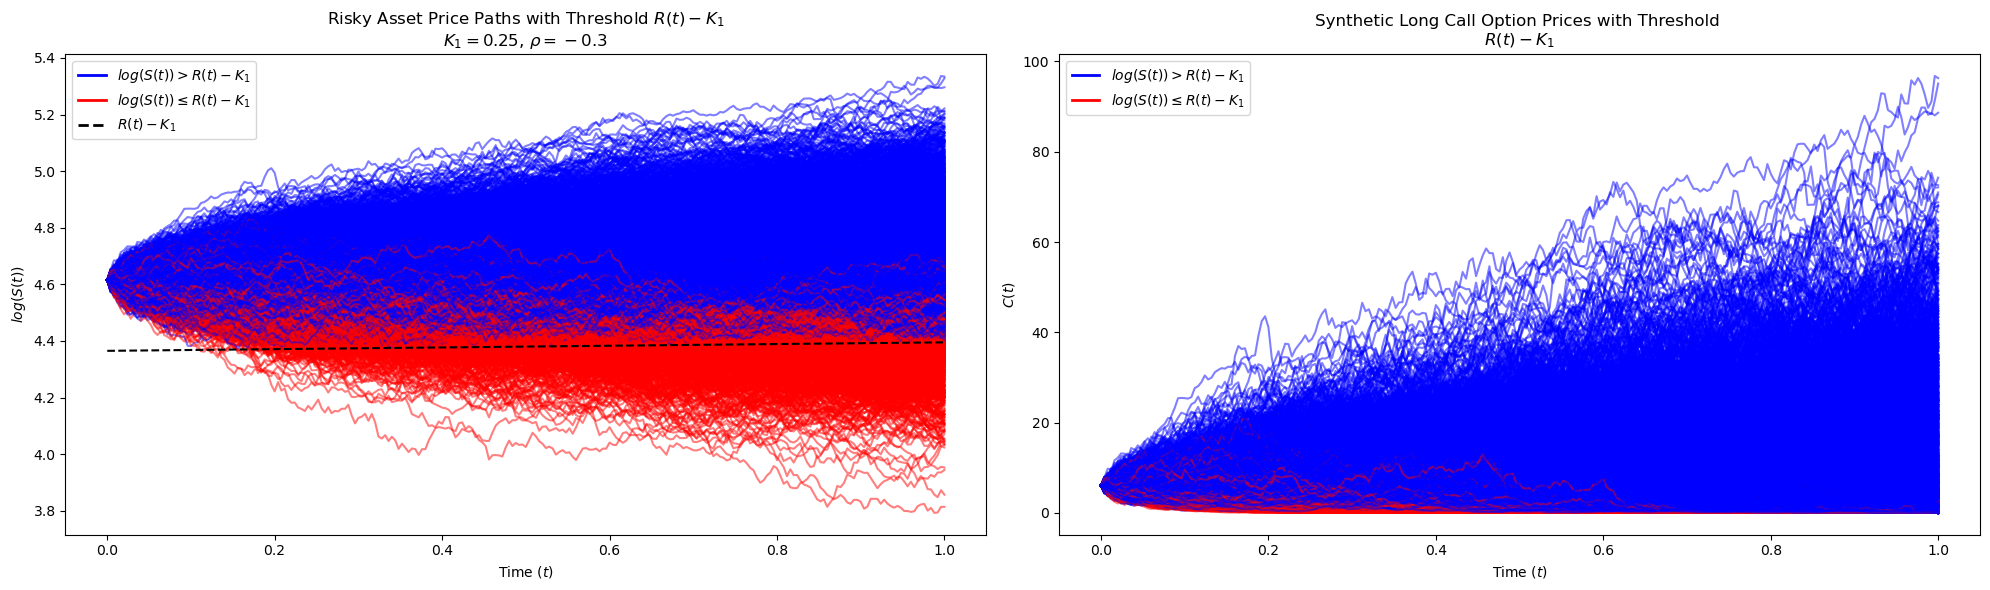

In [4]:
# Buy-and-Hold portfolio with one threshold
rho = -0.3  # Correlation coefficient
single_k1_threshold = 0.25  # Threshold value for k1
dW2 = (rho * dW1) + (np.sqrt(1 - rho**2) * dZ)  # Generate correlated Brownian motion dW2

# Generate stochastic asset prices using geometric Brownian motion with the correlated dW2
s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)

# Calculate the call option prices and their corresponding delta values using the Black-Scholes formula
call_option_prices, call_option_deltas = call_option_price(s_paths_gbm, strike, risk_free_rate, dividend, dt_seq, long_term_vol)

# Create the threshold function for the risky asset price paths
threshold_r_t_k1 = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 - single_k1_threshold

# Create masks for the conditions where asset price paths are above the threshold
above_rt_mask_k1 = np.zeros((n_paths, n_steps+1), dtype=bool)
for i in range(n_paths):
    above_rt_mask_k1[i, :] = np.log1p(s_paths_gbm[i,:]) > threshold_r_t_k1

# Set up the figure with two subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Adding a subtitle with the standard error of sample mean
subtitle_text_1 = f"$K_{1} = {single_k1_threshold}$, $\rho = {rho}$"

# First subplot for Risky Asset Price Paths and Threshold R_t - K1
for i in range(n_paths):
    color = 'blue' if above_rt_mask_k1[i].all() else 'red'  # Color based on if path stays above the threshold
    label_text = f'Path {i+1} (Always Above $K_1$)' if above_rt_mask_k1[i].all() else f'Path {i+1} (Hits Below $K_1$)'
    axs[0].plot(x_axis_t, np.log1p(s_paths_gbm[i]), label=label_text, color=color, alpha=0.5)

axs[0].plot(x_axis_t, threshold_r_t_k1, color='black', label=r'$R_{t} - K_{1}$', linestyle='--')
axs[0].set_xlabel('Time $(t)$')
axs[0].set_ylabel('$log(S(t))$')
axs[0].set_title(f'Risky Asset Price Paths with Threshold $R(t) - K_1$\n$K_1 = {single_k1_threshold}$, $\\rho = {rho}$')

# Custom legend for the first subplot
legend_elements_1 = [
    plt.Line2D([0], [0], color='blue', lw=2, label='$log(S(t)) > R(t) - K_{1}$'),
    plt.Line2D([0], [0], color='red', lw=2, label='$log(S(t)) \leq R(t) - K_{1}$'),
    plt.Line2D([0], [0], color='black', linestyle='--', lw=2, label='$R(t) - K_{1}$')
]
axs[0].legend(handles=legend_elements_1)

# Second subplot for Synthetic Long Call Option Prices with Threshold R_t - K1
for i in range(n_paths):
    color = 'blue' if above_rt_mask_k1[i].all() else 'red'  # Color based on if path stays above the threshold
    label_text = f'Path {i+1} (less than $\\theta + K_{2}$)' if above_rt_mask_k1[i].all() else f'Path {i+1} (greater than or equal to $\\theta + K_{2}$)'
    axs[1].plot(x_axis_t, call_option_prices[i], label=label_text, color=color, alpha=0.5)

axs[1].set_xlabel('Time $(t)$')
axs[1].set_ylabel('$C(t)$')
axs[1].set_title(f'Synthetic Long Call Option Prices with Threshold \n$R(t) - K_1$')

# Custom legend for the second subplot
legend_elements_2 = [
    plt.Line2D([0], [0], color='blue', lw=2, label='$log(S(t)) > R(t) - K_{1}$'),
    plt.Line2D([0], [0], color='red', lw=2, label='$log(S(t)) \leq R(t) - K_{1}$')
]
axs[1].legend(handles=legend_elements_2)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Part 1 (b) - New risk measure values for changing $K_{1}$ and $\rho$ for buy-and-hold portfolio

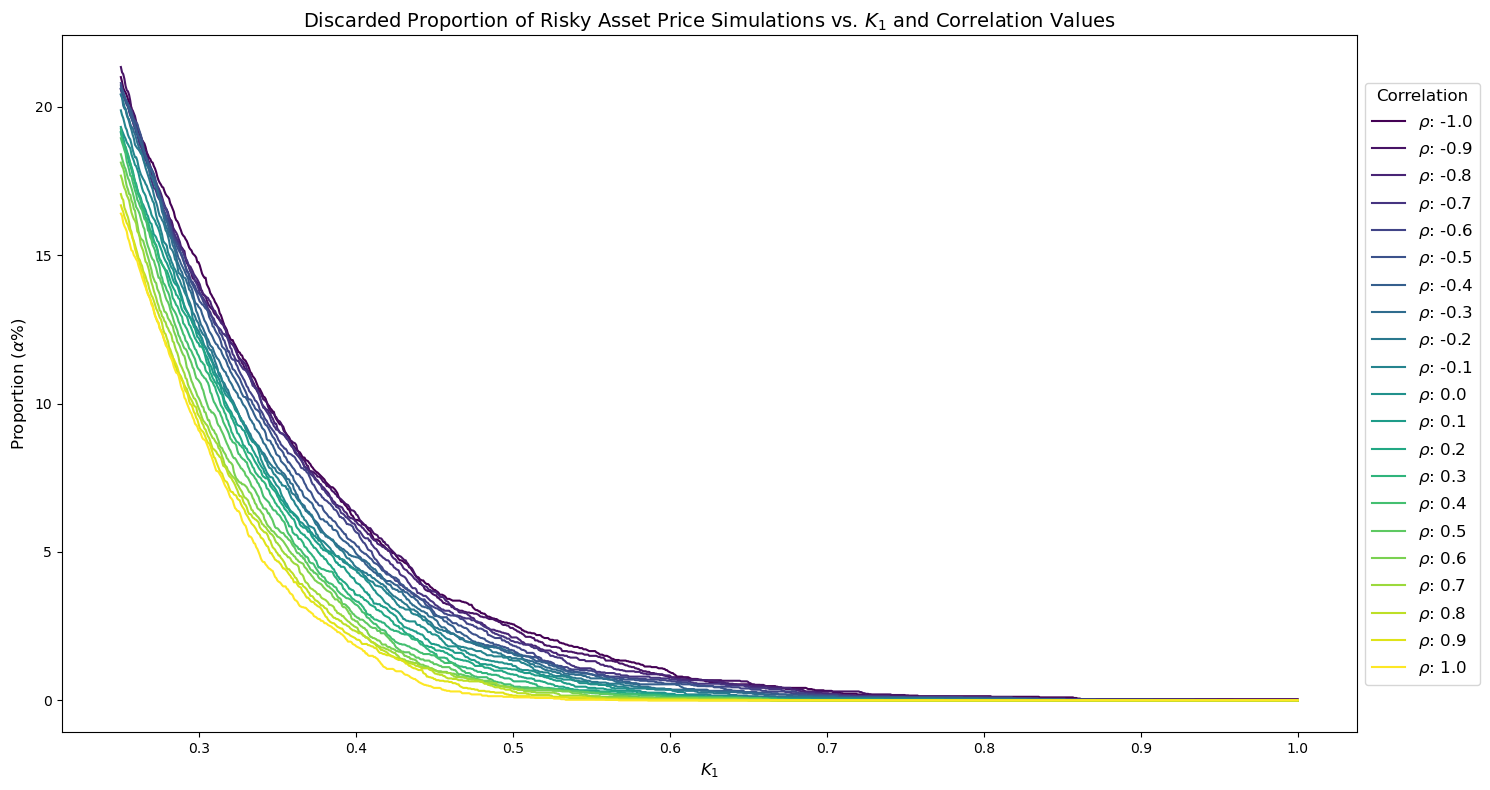

In [5]:
# Generate arrays for rho and K_threshold
rho = np.linspace(-1, 1, 21)  # Create an array of rho values from -1 to 1
threshold_k1_values = np.linspace(0.25, 1, 1001)  # Create an array of threshold values for K1

# Calculate the threshold value R_t based on initial conditions
threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# Initialize array to store results for multiple rho and K_threshold values
multiple_k_thresholds = np.zeros((len(rho), len(threshold_k1_values)))

# Loop over each rho value
for i, rho_value in enumerate(rho):
    # Calculate correlated Brownian motion dW2 using the current rho value
    dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
    # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
    s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)

    # Calculate proportion of paths below the threshold R_t for each K_threshold
    prop_below_rt, _ = calc_prop_above_below_rt_s_paths_portfolio(s_paths_gbm=s_paths_gbm, K_threshold=threshold_k1_values, R_t=threshold_r_t)
    
    # Store the results (proportions below threshold) in the multiple_k_thresholds array
    multiple_k_thresholds[i, :] = prop_below_rt

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 8))

# Plot multiple lines with different colors and labels
colors = plt.cm.viridis(np.linspace(0, 1, len(rho)))  # Color palette
for i, rho_value in enumerate(rho):
    ax.plot(threshold_k1_values, multiple_k_thresholds[i] * 100, label=f'$\\rho$: {round(rho_value, 2)}', color=colors[i])

# Set labels and title with increased font sizes
ax.set_xlabel('$K_{1}$', fontsize=12)
ax.set_ylabel('Proportion ($\\alpha \%$)', fontsize=12)
ax.set_title('Discarded Proportion of Risky Asset Price Simulations vs. $K_{1}$ and Correlation Values', fontsize=14)

# Move legend outside the plot to the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Correlation', title_fontsize='large', fontsize='large')

# Show plot
plt.tight_layout()  # Ensure tight layout
plt.show()

In [6]:
# Define the alpha values for which you want to find k1 values
alpha_values = np.array([0.001, 0.01, 0.025, 0.05, 0.075 ,0.1])

# Initialize dictionaries to store k1 values, new measures, and VaR measures
alpha_to_k1_dict = {}            # To store k1 values
alpha_to_new_measure_dict = {}    # To store new measures
alpha_to_VaR_dict = {}            # To store VaR measures

# Convert alpha values to percentiles for VaR calculation
alpha_percentiles = alpha_values * 100

# Vectorize the process for calculating k1 values for each row in multiple_k_thresholds
for i, row in enumerate(multiple_k_thresholds):
    # Calculate the absolute differences between the row values and each alpha value
    abs_diff = np.abs(row[:, np.newaxis] - alpha_values)
    
    # Find the indices of the minimum absolute differences
    min_indices = np.argmin(abs_diff, axis=0)
    
    # Map each alpha value to the corresponding k1 value
    k1_values = threshold_k1_values[min_indices]
    
    # Store the rounded k1 values in the dictionary
    alpha_to_k1_dict[i] = dict(zip(alpha_values, np.round(k1_values, 5)))

# Loop through each value of rho
for i, rho_value in enumerate(rho):
    new_measures = []  # List to store new measures for different alpha values
    VaR_measure = []   # List to store VaR measures for different alpha values

    # Calculate correlated Brownian motion dW2 using the current rho value
    dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
    # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
    s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
    
    # Compute the portfolio value at time T for each path
    portfolio_value_T = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)

    # Iterate over each alpha value
    for alpha, alpha_percentile in zip(alpha_values, alpha_percentiles):
        # Retrieve the corresponding k1 threshold for the current rho and alpha
        k1_thresh = alpha_to_k1_dict[i][alpha]

        # Calculate rep_r_t based on k1 threshold
        rep_r_t = threshold_r_t - k1_thresh
        
        # Create a mask to check which paths are above rep_r_t
        new_mask = np.log1p(s_paths_gbm) > rep_r_t

        # Check which rows (paths) have all elements above rep_r_t (ignoring the last step)
        all_above_rt_rows = np.all(new_mask[:, :-1], axis=1)
        indices_all_above_rt = np.where(all_above_rt_rows)[0]

        # Calculate new measure (V_phi)
        if len(indices_all_above_rt) > 0:
            rho_phi = V_phi_omega_T(portfolio_value_T[indices_all_above_rt])
        else:
            rho_phi = np.nan  # Handle case where no paths are above rep_r_t

        # Calculate the VaR measure
        var_5_percent = V_phi_VaR(portfolio_value_T, alpha_percentile)

        # Append the new measure and VaR measure to the respective lists
        new_measures.append(np.round(rho_phi, 5))
        VaR_measure.append(np.round(var_5_percent, 5))

    # Store the alpha-to-new-measure and alpha-to-VaR mappings for the current rho
    alpha_to_new_measure_dict[i] = dict(zip(alpha_values, new_measures))
    alpha_to_VaR_dict[i] = dict(zip(alpha_values, VaR_measure))

# Generate the table of results, with the new risk measure, value at risk and the difference betweeen the two, for different rho, alpha and k1 values
generate_table(alpha_to_new_measure_dict=alpha_to_new_measure_dict, alpha_to_k1_dict=alpha_to_k1_dict, alpha_to_VaR_dict=alpha_to_VaR_dict, rho=rho)

╒═══════╤═════════╤════════════╤═════════╤═════════╤═════════════╕
│   Rho │   Alpha │   K1 Value │     New │     VaR │   New - VaR │
╞═══════╪═════════╪════════════╪═════════╪═════════╪═════════════╡
│  -1   │   0.001 │    0.83575 │ 61.171  │ 57.5758 │     3.59524 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.01  │    0.59875 │ 49.8385 │ 45.4172 │     4.42134 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.025 │    0.502   │ 44.4597 │ 39.0196 │     5.44011 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.05  │    0.42175 │ 38.7871 │ 33.1012 │     5.68582 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.075 │    0.379   │ 37.052  │ 29.5958 │     7.45615 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.1   │    0.34375 │ 33.6707 │ 26.2262 │     7.44447 │
├───────┼─────────┼────────────┼─────────┼─────────┼──────────

### Part 1 (b) - New risk measure values for changing $K_{1}$ and $\rho$ for synthetic long position call option portfolio

The following code is for the call option prices (using Black-Scholes), with filtered asset prices using the $K_1$ threshold adjuster.

In [7]:
# Define the alpha values for which you want to find k1 values
alpha_values = np.array([0.001, 0.01, 0.05, 0.1])

# Initialize dictionaries to store k1 values, new measures, and VaR measures
alpha_to_k1_dict = {}            # To store k1 values
alpha_to_new_measure_dict = {}    # To store new measures
alpha_to_VaR_dict = {}            # To store VaR measures

# Convert alpha values to percentiles for VaR calculation
alpha_percentiles = alpha_values * 100

# Vectorize the process for calculating k1 values for each row in multiple_k_thresholds
for i, row in enumerate(multiple_k_thresholds):
    # Calculate the absolute differences between the row values and each alpha value
    abs_diff = np.abs(row[:, np.newaxis] - alpha_values)
    
    # Find the indices of the minimum absolute differences
    min_indices = np.argmin(abs_diff, axis=0)
    
    # Map each alpha value to the corresponding k1 value
    k1_values = threshold_k1_values[min_indices]
    
    # Store the rounded k1 values in the dictionary
    alpha_to_k1_dict[i] = dict(zip(alpha_values, np.round(k1_values, 5)))

# Loop through each value of rho
for i, rho_value in enumerate(rho):
    new_measures = []  # List to store new measures for different alpha values
    VaR_measure = []   # List to store VaR measures for different alpha values

    # Calculate correlated Brownian motion dW2 using the current rho value
    dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
    # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
    s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
    
    # Calculate the call option and their corresponding delta values using the Black-Scholes formula
    call_price, call_delta = call_option_price(s_paths_gbm, strike, risk_free_rate, dividend, dt_seq, long_term_vol)

    # Create synthetic delta hedged call option prices
    call_delta_hedged_prices, _ = call_option_delta_hedge_process(number_of_shares=number_of_shares, hedging_frequency=hedging_frequency,
                                    risk_free_rate=risk_free_rate, s_paths=s_paths_gbm, 
                                    option_prices=call_price, option_deltas=call_delta, 
                                    n_steps=n_steps, n_paths=n_paths)

    # Compute the portfolio value at time T for each path
    call_portfolio_value_T = long_call_portfolio_payoff_T(hedged_p=call_delta_hedged_prices, call_p=call_price, r=risk_free_rate, t=T)

    # Iterate over each alpha value
    for alpha, alpha_percentile in zip(alpha_values, alpha_percentiles):
        # Retrieve the corresponding k1 threshold for the current rho and alpha
        k1_thresh = alpha_to_k1_dict[i][alpha]

        # Calculate rep_r_t based on k1 threshold
        rep_r_t = threshold_r_t - k1_thresh

        # Create a mask to check which paths are above rep_r_t
        new_mask = np.log1p(s_paths_gbm) > rep_r_t

        # Check which rows (paths) have all elements above rep_r_t (ignoring the last step)
        all_above_rt_rows = np.all(new_mask[:, :-1], axis=1)
        indices_all_above_rt = np.where(all_above_rt_rows)[0]

        # Calculate new measure (v_phi)
        if len(indices_all_above_rt) > 0:
            rho_phi = V_phi_omega_T(call_portfolio_value_T[indices_all_above_rt])
        else:
            rho_phi = np.nan  # Handle case where no paths are above rep_r_t

        # Calculate the VaR measure
        var_5_percent = V_phi_VaR(call_portfolio_value_T, alpha_percentile)

        # Append the new measure and VaR measure to the respective lists
        new_measures.append(np.round(rho_phi, 5))
        VaR_measure.append(np.round(var_5_percent, 5))

    # Store the alpha-to-new-measure and alpha-to-VaR mappings for the current rho
    alpha_to_new_measure_dict[i] = dict(zip(alpha_values, new_measures))
    alpha_to_VaR_dict[i] = dict(zip(alpha_values, VaR_measure))
    
# Generate the table of results, with the new risk measure, value at risk and the difference betweeen the two, for different rho, alpha and k1 values
generate_table(alpha_to_new_measure_dict=alpha_to_new_measure_dict, alpha_to_k1_dict=alpha_to_k1_dict, alpha_to_VaR_dict=alpha_to_VaR_dict, rho=rho)

C:\Users\AliPe\AppData\Local\Temp\ipykernel_7200\2323933894.py:90: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r - q + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))


╒═══════╤═════════╤════════════╤══════════╤══════════╤═════════════╕
│   Rho │   Alpha │   K1 Value │      New │      VaR │   New - VaR │
╞═══════╪═════════╪════════════╪══════════╪══════════╪═════════════╡
│  -1   │   0.001 │    0.83575 │  9.12418 │  8.67245 │     0.45173 │
├───────┼─────────┼────────────┼──────────┼──────────┼─────────────┤
│  -1   │   0.01  │    0.59875 │  9.12418 │  7.91486 │     1.20932 │
├───────┼─────────┼────────────┼──────────┼──────────┼─────────────┤
│  -1   │   0.05  │    0.42175 │  8.83325 │  7.35748 │     1.47577 │
├───────┼─────────┼────────────┼──────────┼──────────┼─────────────┤
│  -1   │   0.1   │    0.34375 │  8.70844 │  7.00685 │     1.70159 │
├───────┼─────────┼────────────┼──────────┼──────────┼─────────────┤
│  -0.9 │   0.001 │    0.77875 │  9.74012 │  8.99336 │     0.74676 │
├───────┼─────────┼────────────┼──────────┼──────────┼─────────────┤
│  -0.9 │   0.01  │    0.58225 │  9.74012 │  8.10872 │     1.6314  │
├───────┼─────────┼────────────┼──

### Part 1 (b) - New risk measure values for changing $K_{1}$ and $\rho$ for synthetic short position for call option portfolio

The following code is for the call option prices (using Black-Scholes), with filtered asset prices using the $K_1$ threshold adjuster.

In [8]:
# Define the alpha values for which you want to find k1 values
alpha_values = np.array([0.001, 0.01, 0.05, 0.1])

# Initialize dictionaries to store k1 values, new measures, and VaR measures
alpha_to_k1_dict = {}            # To store k1 values
alpha_to_new_measure_dict = {}    # To store new measures
alpha_to_VaR_dict = {}            # To store VaR measures

# Convert alpha values to percentiles for VaR calculation
alpha_percentiles = alpha_values * 100

# Vectorize the process for calculating k1 values for each row in multiple_k_thresholds
for i, row in enumerate(multiple_k_thresholds):
    # Calculate the absolute differences between the row values and each alpha value
    abs_diff = np.abs(row[:, np.newaxis] - alpha_values)
    
    # Find the indices of the minimum absolute differences
    min_indices = np.argmin(abs_diff, axis=0)
    
    # Map each alpha value to the corresponding k1 value
    k1_values = threshold_k1_values[min_indices]
    
    # Store the rounded k1 values in the dictionary
    alpha_to_k1_dict[i] = dict(zip(alpha_values, np.round(k1_values, 5)))
    
# Loop through each value of rho
for i, rho_value in enumerate(rho):
    new_measures = []  # List to store new measures for different alpha values
    VaR_measure = []   # List to store VaR measures for different alpha values

    # Calculate correlated Brownian motion dW2 using the current rho value
    dW2 = rho_value * dW1 + np.sqrt(1 - rho_value**2) * dZ
    
    # Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
    s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)
    
    # Calculate the call option and their corresponding delta values using the Black-Scholes formula
    call_price, call_delta = call_option_price(s_paths_gbm, strike, risk_free_rate, dividend, dt_seq, long_term_vol)

    # Create synthetic delta hedged call option prices
    call_delta_hedged_prices, _ = call_option_delta_hedge_process(number_of_shares=number_of_shares, hedging_frequency=hedging_frequency,
                                    risk_free_rate=risk_free_rate, s_paths=s_paths_gbm, 
                                    option_prices=call_price, option_deltas=call_delta, 
                                    n_steps=n_steps, n_paths=n_paths)
    
    # Compute the portfolio value at time T for each path
    call_portfolio_value_T = short_call_portfolio_payoff_T(hedged_p=call_delta_hedged_prices, call_p=call_price, t=n_steps)

    # Iterate over each alpha value
    for alpha, alpha_percentile in zip(alpha_values, alpha_percentiles):
        # Retrieve the corresponding k1 threshold for the current rho and alpha
        k1_thresh = alpha_to_k1_dict[i][alpha]

        # Calculate rep_r_t based on k1 threshold
        rep_r_t = threshold_r_t - k1_thresh

        # Create a mask to check which paths are above rep_r_t
        new_mask = np.log1p(s_paths_gbm) > rep_r_t

        # Check which rows (paths) have all elements above rep_r_t (ignoring the last step)
        all_above_rt_rows = np.all(new_mask[:, :-1], axis=1)
        indices_all_above_rt = np.where(all_above_rt_rows)[0]

        # Calculate new measure (v_phi)
        if len(indices_all_above_rt) > 0:
            rho_phi = V_phi_omega_T(call_portfolio_value_T[indices_all_above_rt])
        else:
            rho_phi = np.nan  # Handle case where no paths are above rep_r_t

        # Calculate the VaR measure
        var_5_percent = V_phi_VaR(call_portfolio_value_T, alpha_percentile)

        # Append the new measure and VaR measure to the respective lists
        new_measures.append(np.round(rho_phi, 5))
        VaR_measure.append(np.round(var_5_percent, 5))

    # Store the alpha-to-new-measure and alpha-to-VaR mappings for the current rho
    alpha_to_new_measure_dict[i] = dict(zip(alpha_values, new_measures))
    alpha_to_VaR_dict[i] = dict(zip(alpha_values, VaR_measure))
    
# Generate the table of results, with the new risk measure, value at risk and the difference betweeen the two, for different rho, alpha and k1 values
generate_table(alpha_to_new_measure_dict=alpha_to_new_measure_dict, alpha_to_k1_dict=alpha_to_k1_dict, alpha_to_VaR_dict=alpha_to_VaR_dict, rho=rho)

C:\Users\AliPe\AppData\Local\Temp\ipykernel_7200\2323933894.py:90: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r - q + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))


╒═══════╤═════════╤════════════╤═════════╤═════════╤═════════════╕
│   Rho │   Alpha │   K1 Value │     New │     VaR │   New - VaR │
╞═══════╪═════════╪════════════╪═════════╪═════════╪═════════════╡
│  -1   │   0.001 │    0.83575 │ 1.94656 │ 1.34347 │     0.60309 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.01  │    0.59875 │ 1.94656 │ 0.87626 │     1.0703  │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.05  │    0.42175 │ 1.94656 │ 0.56134 │     1.38522 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -1   │   0.1   │    0.34375 │ 1.94656 │ 0.41469 │     1.53187 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -0.9 │   0.001 │    0.77875 │ 3.21116 │ 1.88865 │     1.32251 │
├───────┼─────────┼────────────┼─────────┼─────────┼─────────────┤
│  -0.9 │   0.01  │    0.58225 │ 3.21116 │ 1.24851 │     1.96265 │
├───────┼─────────┼────────────┼─────────┼─────────┼──────────

### Part 1 (C) - New risk measure values for half-time buy-and-hold portfolio

In [9]:
# Consider the largest K1 amount to include all the portfolio values
k1 = 1
rho = 0.5
weight_q = 0.25
alpha_values = [0.01, 0.05, 0.10]

# Calculate dW2 using the correlation coefficient rho
dW2 = (rho * dW1) + (np.sqrt(1 - rho**2) * dZ)

# Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)

# Exclude proportion that are extreme.
log_of_asset_prices = np.log1p(s_paths_gbm)  # Log transformation of asset prices

# Calculate the threshold value R_t based on initial conditions
threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# Pre-compute the portfolio value at time T for each path
portfolio_value_T = buy_hold_portfolio_payoff_T(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T)
value_of_portfolio_T_2 = buy_hold_portfolio_payoff_T_2(s=s_paths_gbm, s0=s0, r=risk_free_rate, T=T, n_steps=n_steps)

# Find the minimum distance. If it is negative then they are below (threshold - k1), so we remove them.
min_distances = np.min(log_of_asset_prices - (threshold_r_t - k1), axis=1)
min_distances[min_distances < 0] = np.nan

# Ensure that the distances are set to NaN if corresponding portfolio value is NaN
min_distances[np.isnan(portfolio_value_T)] = np.nan

# Average realized volaitlity from the CIR process simulations
average_realized_volatility = np.mean(np.sqrt(cir_vol_paths), axis=1)

# Create DataFrame to store calculated values
portfolio_df = pd.DataFrame({
    'Average_Realized_Volatility': average_realized_volatility,
    'Portfolio_Value_T': portfolio_value_T,
    'Portfolio_Value_T_2': value_of_portfolio_T_2,
    'Min_Distances': min_distances
})

# Add risk measure selection to portfolio_df
portfolio_df['Ex3_Risk_Measure'] = ((1 - weight_q) * portfolio_df['Portfolio_Value_T']) + (weight_q * portfolio_df['Portfolio_Value_T_2'])

# Calculate percent omitted
percent_omitted = (portfolio_df['Portfolio_Value_T'].isna().sum() / n_paths) * 100

# Calculate new risk measure value
new_risk_measure_value = (-1) * portfolio_df['Portfolio_Value_T'].min(skipna=True)
print(f'The full time risk measure for buy-and-hold position is {np.round(new_risk_measure_value, 5)} with correlation value of {rho} and K1 = {single_k1_threshold}')

# Calculate example 3 new risk measure value
ex3_risk_measure_value = (-1) * portfolio_df['Ex3_Risk_Measure'].min(skipna=True)
print(f'The half time risk measure for buy-and-hold position is {np.round(ex3_risk_measure_value, 5)} with correlation value of {rho} and K1 = {single_k1_threshold}')


# Put the portfolio values in order and remove NaN values
portfolio_df = portfolio_df[portfolio_df['Portfolio_Value_T'].notna()]
portfolio_df = portfolio_df.sort_values(by='Min_Distances')

# Now find and discard alpha values from the left. These are the distances that are closest to the y-axis.
# After discarding alpha portfolio values, find the minimum points (our risk measures).
second_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[0])))
first_minimum_df = second_portfolio_df[second_portfolio_df['Portfolio_Value_T'] == second_portfolio_df['Portfolio_Value_T'].min()]

third_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[1])))
second_minimum_df = third_portfolio_df[third_portfolio_df['Portfolio_Value_T'] == third_portfolio_df['Portfolio_Value_T'].min()]

fourth_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[2])))
third_minimum_df = fourth_portfolio_df[fourth_portfolio_df['Portfolio_Value_T'] == fourth_portfolio_df['Portfolio_Value_T'].min()]

# Create the intercepts for alpha values. A line in the plot is an intercept which shows the
# exclusion of alpha amount trajectories.
upper_intercept = portfolio_df[portfolio_df['Portfolio_Value_T'] == max(portfolio_df['Portfolio_Value_T'])]
lower_intercept = portfolio_df[portfolio_df['Portfolio_Value_T'] == min(portfolio_df['Portfolio_Value_T'])]

intercept = pd.DataFrame({
    "y_values": np.linspace(float(lower_intercept.iloc[0, 1]) - 5, float(upper_intercept.iloc[0, 1]), n_steps),
    "x_values_1": np.repeat(k1, n_steps),
    "x_values_2": np.repeat(float(second_portfolio_df.iloc[0, 3]), n_steps),
    "x_values_3": np.repeat(float(third_portfolio_df.iloc[0, 3]), n_steps),
    "x_values_4": np.repeat(float(fourth_portfolio_df.iloc[0, 3]), n_steps)
})

The full time risk measure for buy-and-hold position is 51.84805 with correlation value of 0.5 and K1 = 0.25
The half time risk measure for buy-and-hold position is 47.42925 with correlation value of 0.5 and K1 = 0.25


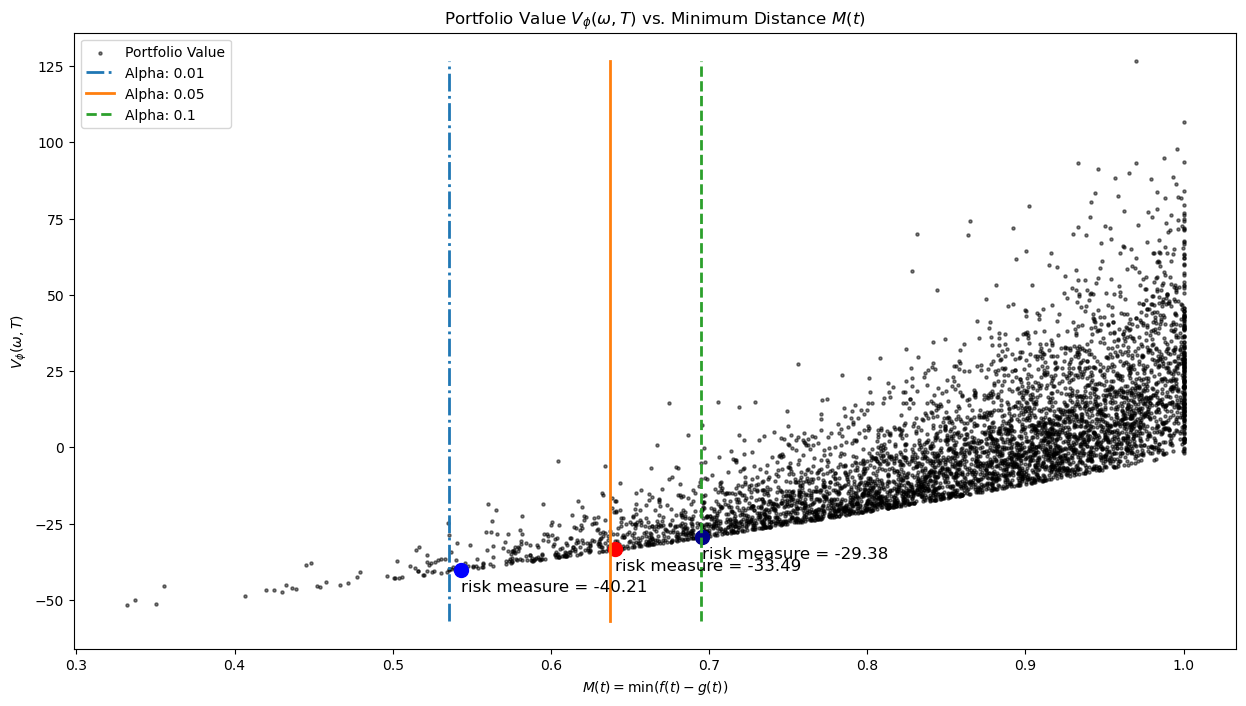

In [10]:
# Scatter plot
plt.figure(figsize=(15, 8))  # Set the figure size
plt.scatter(portfolio_df['Min_Distances'], portfolio_df['Portfolio_Value_T'], color='black', s=5, label='Portfolio Value', alpha=0.5)  # Scatter plot of portfolio values
plt.plot(intercept['x_values_2'], intercept['y_values'], linestyle='-.', linewidth=2, label=f'Alpha: {alpha_values[0]}')  # Plot first intercept line
plt.plot(intercept['x_values_3'], intercept['y_values'], linestyle='-', linewidth=2, label=f'Alpha: {alpha_values[1]}')  # Plot second intercept line
plt.plot(intercept['x_values_4'], intercept['y_values'], linestyle='--', linewidth=2, label=f'Alpha: {alpha_values[2]}')  # Plot third intercept line

# Highlight first minimum
plt.scatter(first_minimum_df['Min_Distances'], first_minimum_df['Portfolio_Value_T'], color='blue', s=100, marker='o')  # Scatter plot of first minimum
for i, txt in enumerate(first_minimum_df['Portfolio_Value_T']):  # Annotate each point of the first minimum
    plt.annotate(f"risk measure = {round(txt, 2)}", (first_minimum_df['Min_Distances'].iloc[i], first_minimum_df['Portfolio_Value_T'].iloc[i]-7), fontsize=12)

# Highlight second minimum
plt.scatter(second_minimum_df['Min_Distances'], second_minimum_df['Portfolio_Value_T'], color='red', s=100, marker='o')  # Scatter plot of second minimum
for i, txt in enumerate(second_minimum_df['Portfolio_Value_T']):  # Annotate each point of the second minimum
    plt.annotate(f"risk measure = {round(txt, 2)}", (second_minimum_df['Min_Distances'].iloc[i], second_minimum_df['Portfolio_Value_T'].iloc[i]-7), fontsize=12)

# Highlight third minimum
plt.scatter(third_minimum_df['Min_Distances'], third_minimum_df['Portfolio_Value_T'], color='darkblue', s=100, marker='o')  # Scatter plot of third minimum
for i, txt in enumerate(third_minimum_df['Portfolio_Value_T']):  # Annotate each point of the third minimum
    plt.annotate(f"risk measure = {round(txt, 2)}", (third_minimum_df['Min_Distances'].iloc[i], third_minimum_df['Portfolio_Value_T'].iloc[i]-7), fontsize=12)

# Adjust limits and labels
plt.xlabel('$M(t) = \min(f(t) - g(t))$')  # X-axis label with LaTeX formatting
plt.ylabel('$V_{\phi}(\omega, T)$')  # Y-axis label with LaTeX formatting
plt.title('Portfolio Value $V_{\phi}(\omega, T)$ vs. Minimum Distance $M(t)$')  # Plot title with LaTeX formatting

# Add legend
plt.legend()

# Show plot
plt.show()

### Part 1 (C) - New risk measure values for half-time synthetic long position in call option portfolio

In [11]:
# Consider the largest K1 amount to include all the portfolio values
k1 = 1
rho = 0.5
weight_q = 0.25
alpha_values = [0.01, 0.05, 0.10]
dW2 = (rho * dW1) + (np.sqrt(1 - rho**2) * dZ)

# Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)

# # Exclude proportion that are extreme.
log_of_asset_prices = np.log1p(s_paths_gbm)  # Log transformation of asset prices

# Calculate the threshold value R_t based on initial conditions
threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# Calculate the call option and their corresponding delta values using the Black-Scholes formula
call_price, call_delta = call_option_price(s_paths_gbm, strike, risk_free_rate, dividend, dt_seq, long_term_vol)

# Create synthetic delta hedged call option prices
call_delta_hedged_prices, _ = call_option_delta_hedge_process(number_of_shares=number_of_shares, hedging_frequency=hedging_frequency,
                                    risk_free_rate=risk_free_rate, s_paths=s_paths_gbm, 
                                    option_prices=call_price, option_deltas=call_delta, 
                                    n_steps=n_steps, n_paths=n_paths)
    
# Pre-compute the portfolio value at time T for each path
call_portfolio_value_T = long_call_portfolio_payoff_T(hedged_p=call_delta_hedged_prices, call_p=call_price, r=risk_free_rate, t=T)
call_value_of_portfolio_T_2 = long_call_portfolio_payoff_T_2(hedged_p=call_delta_hedged_prices, call_p=call_price, r=risk_free_rate, t=T, n_steps=n_steps)
 
# Find the minimum distance. If it is negative then they are below (threshold - k1), so we remove them.
min_distances = np.min(log_of_asset_prices - (threshold_r_t - k1), axis=1)
min_distances[min_distances < 0] = np.nan

# Ensure that the distances are set to NaN if corresponding portfolio value is NaN
min_distances[np.isnan(call_portfolio_value_T)] = np.nan

# Average realized volaitlity from the CIR process simulations
average_realized_volatility = np.mean(np.sqrt(cir_vol_paths), axis=1)

portfolio_df = pd.DataFrame(data = {
    'Average_Realized_Volatility': average_realized_volatility,
    'Portfolio_Value_T': call_portfolio_value_T,
    'Portfolio_Value_T_2': call_value_of_portfolio_T_2,
    'Min_Distances': min_distances
})

# Add risk measure selection to portfolio_df
portfolio_df['Ex3_Risk_Measure'] = ((1 - weight_q) * portfolio_df['Portfolio_Value_T']) + (weight_q * portfolio_df['Portfolio_Value_T_2'])

# Calculate percent omitted
percent_omitted = (portfolio_df['Portfolio_Value_T'].isna().sum() / n_paths) * 100

# Calculate new risk measure value
new_risk_measure_value = (-1) * portfolio_df['Portfolio_Value_T'].min(skipna=True)
print(f'The full time risk measure for synthetic long position call option is {np.round(new_risk_measure_value, 5)} with correlation value of {rho} and K1 = {single_k1_threshold}')

# Calculate example 3 new risk measure value
ex3_risk_measure_value = (-1) * portfolio_df['Ex3_Risk_Measure'].min(skipna=True)
print(f'The half time risk measure for synthetic long position call option is {np.round(ex3_risk_measure_value, 5)} with correlation value of {rho} and K1 = {single_k1_threshold}')

# Put the portfolio values in order
portfolio_df = portfolio_df[portfolio_df['Portfolio_Value_T'] != "NA"]
portfolio_df = portfolio_df.sort_values(by='Min_Distances')

# Now find and discard alpha values from the left. These are the distances that are closest to the y-axis.
# After discarding alpha portfolio values, find the minimum points (our risk measures).
second_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[0])))
first_minimum_df = second_portfolio_df[second_portfolio_df['Portfolio_Value_T'] == second_portfolio_df['Portfolio_Value_T'].min()]

third_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[1])))
second_minimum_df = third_portfolio_df[third_portfolio_df['Portfolio_Value_T'] == third_portfolio_df['Portfolio_Value_T'].min()]

fourth_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[2])))
third_minimum_df = fourth_portfolio_df[fourth_portfolio_df['Portfolio_Value_T'] == fourth_portfolio_df['Portfolio_Value_T'].min()]

# Create the intercepts for alpha values. A line in the plot is an intercept which shows the
# exclusion of alpha amount trajectories.
upper_intercept = portfolio_df[portfolio_df['Portfolio_Value_T'] == max(portfolio_df['Portfolio_Value_T'])]
lower_intercept = portfolio_df[portfolio_df['Portfolio_Value_T'] == min(portfolio_df['Portfolio_Value_T'])]

intercept = pd.DataFrame({
    "y_values": np.linspace(float(lower_intercept.iloc[0, 1]) - 5, float(upper_intercept.iloc[0, 1]), n_steps),
    "x_values_1": np.repeat(k1, n_steps),
    "x_values_2": np.repeat(float(second_portfolio_df.iloc[0, 3]), n_steps),
    "x_values_3": np.repeat(float(third_portfolio_df.iloc[0, 3]), n_steps),
    "x_values_4": np.repeat(float(fourth_portfolio_df.iloc[0, 3]), n_steps)
})

C:\Users\AliPe\AppData\Local\Temp\ipykernel_7200\2323933894.py:90: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r - q + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))


The full time risk measure for synthetic long position call option is 11.00269 with correlation value of 0.5 and K1 = 0.25
The half time risk measure for synthetic long position call option is 10.11269 with correlation value of 0.5 and K1 = 0.25


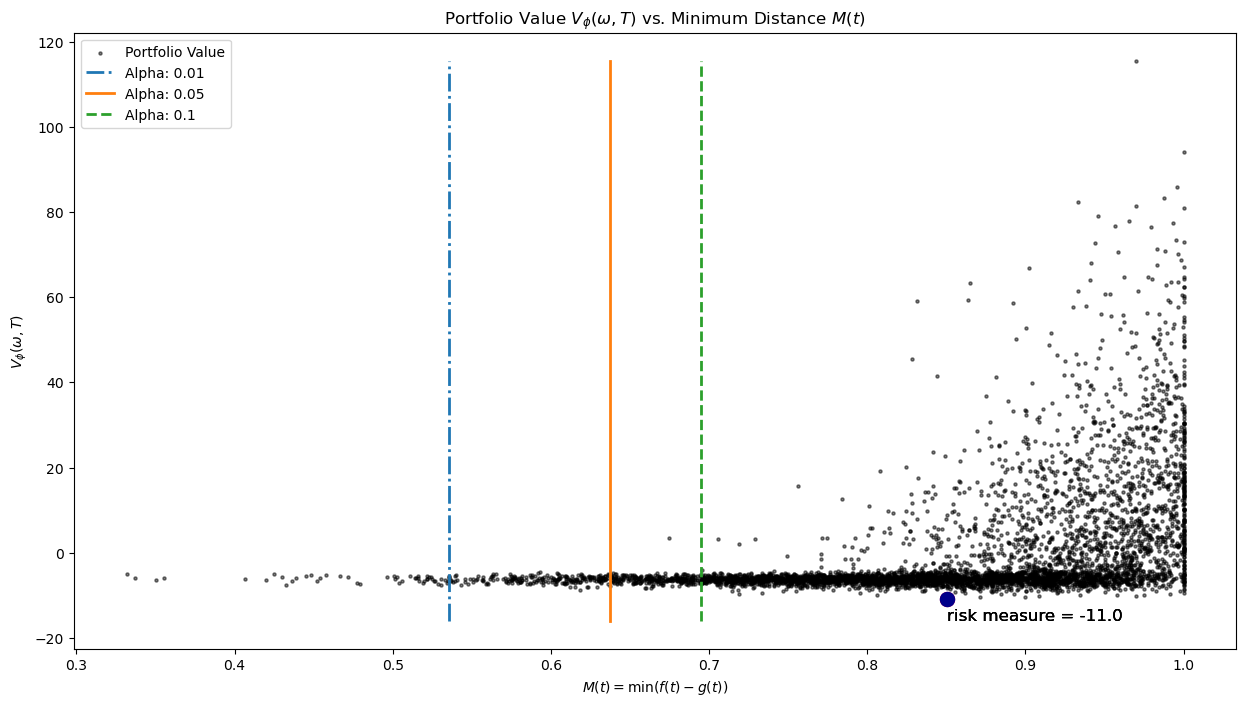

In [12]:
plt.figure(figsize=(15, 8))

# Scatter plot
plt.scatter(portfolio_df['Min_Distances'], portfolio_df['Portfolio_Value_T'], color='black', s=5, label='Portfolio Value', alpha=0.5)

# Plot intercept lines
plt.plot(intercept['x_values_2'], intercept['y_values'], linestyle='-.', linewidth=2, label=f'Alpha: {alpha_values[0]}')
plt.plot(intercept['x_values_3'], intercept['y_values'], linestyle='-', linewidth=2, label=f'Alpha: {alpha_values[1]}')
plt.plot(intercept['x_values_4'], intercept['y_values'], linestyle='--', linewidth=2, label=f'Alpha: {alpha_values[2]}')

# Highlight first minimum
plt.scatter(first_minimum_df['Min_Distances'], first_minimum_df['Portfolio_Value_T'], color='blue', s=100, marker='o')
for i, txt in enumerate(first_minimum_df['Portfolio_Value_T']):
    plt.annotate(f"risk measure = {round(txt, 2)}", (first_minimum_df['Min_Distances'].iloc[i], first_minimum_df['Portfolio_Value_T'].iloc[i]-5), fontsize=12)

# Highlight second minimum
plt.scatter(second_minimum_df['Min_Distances'], second_minimum_df['Portfolio_Value_T'], color='red', s=100, marker='o')
for i, txt in enumerate(second_minimum_df['Portfolio_Value_T']):
    plt.annotate(f"risk measure = {round(txt, 2)}", (second_minimum_df['Min_Distances'].iloc[i], second_minimum_df['Portfolio_Value_T'].iloc[i]-5), fontsize=12)

# Highlight third minimum
plt.scatter(third_minimum_df['Min_Distances'], third_minimum_df['Portfolio_Value_T'], color='darkblue', s=100, marker='o')
for i, txt in enumerate(third_minimum_df['Portfolio_Value_T']):
    plt.annotate(f"risk measure = {round(txt, 2)}", (third_minimum_df['Min_Distances'].iloc[i], third_minimum_df['Portfolio_Value_T'].iloc[i]-5), fontsize=12)

# Adjust limits
plt.xlabel('$M(t) = \min(f(t) - g(t))$')  # X-axis label with LaTeX formatting
plt.ylabel('$V_{\phi}(\omega, T)$')  # Y-axis label with LaTeX formatting
plt.title('Portfolio Value $V_{\phi}(\omega, T)$ vs. Minimum Distance $M(t)$')  # Plot title with LaTeX formatting

# Add legend
plt.legend()

# Show plot
plt.show()

### Part 1 (C) - New risk measure values for half-time synthetic short position in call option portfolio

In [13]:
# Consider the largest K1 amount to include all the portfolio values
k1 = 1
rho = 0.5
weight_q = 0.25
alpha_values = [0.01, 0.05, 0.10]
dW2 = (rho * dW1) + (np.sqrt(1 - rho**2) * dZ)
upper_bound = 5
lower_bound = -5

# Simulate the risky asset price paths using geometric Brownian motion with the correlated dW2
s_paths_gbm = simulate_gbm(mu=mu, sigma=stoc_vol, T=dt, n_steps=n_steps, n_paths=n_paths, s0=s0, dW=dW2)

# # Exclude proportion that are extreme.
log_of_asset_prices = np.log1p(s_paths_gbm)  # Log transformation of asset prices

# Calculate the threshold value R_t based on initial conditions
threshold_r_t = (mu - (0.5 * long_term_vol**2)) * (np.arange(n_steps+1) * dt) + log_s0 

# Calculate the call option and their corresponding delta values using the Black-Scholes formula
call_price, call_delta = call_option_price(s_paths_gbm, strike, risk_free_rate, dividend, dt_seq, long_term_vol)

# Create synthetic delta hedged call option prices
call_delta_hedged_prices, _ = call_option_delta_hedge_process(number_of_shares=number_of_shares, hedging_frequency=hedging_frequency,
                                    risk_free_rate=risk_free_rate, s_paths=s_paths_gbm, 
                                    option_prices=call_price, option_deltas=call_delta, 
                                    n_steps=n_steps, n_paths=n_paths)
    
# Pre-compute the portfolio value at time T for each path
call_portfolio_value_T = short_call_portfolio_payoff_T(hedged_p=call_delta_hedged_prices, call_p=call_price, t=n_steps)
call_value_of_portfolio_T_2 = short_call_portfolio_payoff_T_2(hedged_p=call_delta_hedged_prices, call_p=call_price, t=n_steps)
 
# Find the minimum distance. If it is negative then they are below (threshold - k1), so we remove them.
min_distances = np.min(log_of_asset_prices - (threshold_r_t - k1), axis=1)
min_distances[min_distances < 0] = np.nan

# Ensure that the distances are set to NaN if corresponding portfolio value is NaN
min_distances[np.isnan(call_portfolio_value_T)] = np.nan

# Average realized volaitlity from the CIR process simulations
average_realized_volatility = np.mean(np.sqrt(cir_vol_paths), axis=1)

portfolio_df = pd.DataFrame(data = {
    'Average_Realized_Volatility': average_realized_volatility,
    'Portfolio_Value_T': call_portfolio_value_T,
    'Portfolio_Value_T_2': call_value_of_portfolio_T_2,
    'Min_Distances': min_distances
})

# Add risk measure selection to portfolio_df
portfolio_df['Ex3_Risk_Measure'] = ((1 - weight_q) * portfolio_df['Portfolio_Value_T']) + (weight_q * portfolio_df['Portfolio_Value_T_2'])

# Calculate percent omitted
percent_omitted = (portfolio_df['Portfolio_Value_T'].isna().sum() / n_paths) * 100

# Calculate new risk measure value
new_risk_measure_value = (-1) * portfolio_df['Portfolio_Value_T'].min(skipna=True)
print(f'The full time risk measure for synthetic short position call option is {np.round(new_risk_measure_value, 5)} with correlation value of {rho} and K1 = {single_k1_threshold}')

# Calculate example 3 new risk measure value
ex3_risk_measure_value = (-1) * portfolio_df['Ex3_Risk_Measure'].min(skipna=True)
print(f'The half time risk measure for synthetic short position call option is {np.round(ex3_risk_measure_value, 5)} with correlation value of {rho} and K1 = {single_k1_threshold}')

# Put the portfolio values in order
portfolio_df = portfolio_df[portfolio_df['Portfolio_Value_T'] != "NA"]
portfolio_df = portfolio_df.sort_values(by='Min_Distances')

# Now find and discard alpha values from the left. These are the distances that are closest to the y-axis.
# After discarding alpha portfolio values, find the minimum points (our risk measures).
second_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[0])))
first_minimum_df = second_portfolio_df[second_portfolio_df['Portfolio_Value_T'] == second_portfolio_df['Portfolio_Value_T'].min()]

third_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[1])))
second_minimum_df = third_portfolio_df[third_portfolio_df['Portfolio_Value_T'] == third_portfolio_df['Portfolio_Value_T'].min()]

fourth_portfolio_df = portfolio_df.tail(int(n_paths - (n_paths * alpha_values[2])))
third_minimum_df = fourth_portfolio_df[fourth_portfolio_df['Portfolio_Value_T'] == fourth_portfolio_df['Portfolio_Value_T'].min()]

# Create the intercepts for alpha values. A line in the plot is an intercept which shows the
# exclusion of alpha amount trajectories.
upper_intercept = portfolio_df[portfolio_df['Portfolio_Value_T'] == max(portfolio_df['Portfolio_Value_T'])]
lower_intercept = portfolio_df[portfolio_df['Portfolio_Value_T'] == min(portfolio_df['Portfolio_Value_T'])]

intercept = pd.DataFrame({
    "y_values": np.linspace(upper_bound, lower_bound, n_steps),
    "x_values_1": np.repeat(k1, n_steps),
    "x_values_2": np.repeat(float(second_portfolio_df.iloc[0, 3]), n_steps),
    "x_values_3": np.repeat(float(third_portfolio_df.iloc[0, 3]), n_steps),
    "x_values_4": np.repeat(float(fourth_portfolio_df.iloc[0, 3]), n_steps)
})


C:\Users\AliPe\AppData\Local\Temp\ipykernel_7200\2323933894.py:90: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r - q + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))


The full time risk measure for synthetic short position call option is 4.25037 with correlation value of 0.5 and K1 = 0.25
The half time risk measure for synthetic short position call option is 3.39892 with correlation value of 0.5 and K1 = 0.25


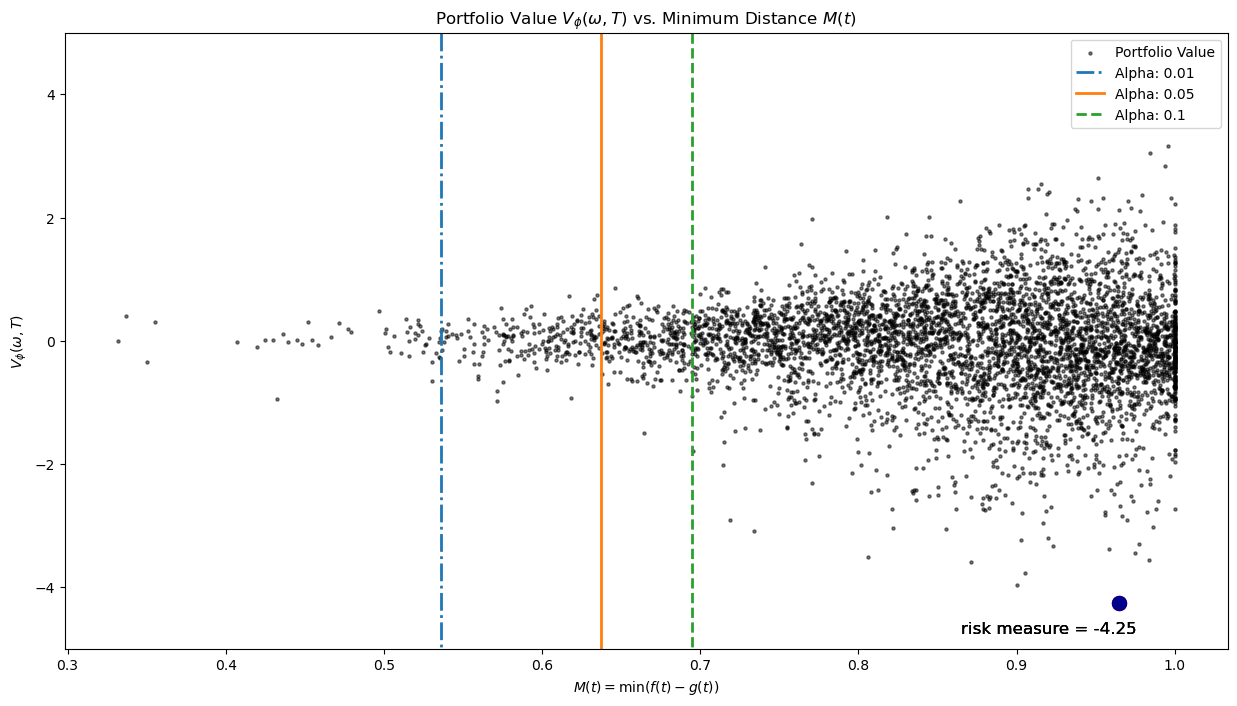

In [14]:
plt.figure(figsize=(15, 8))

# Scatter plot
plt.scatter(portfolio_df['Min_Distances'], portfolio_df['Portfolio_Value_T'], color='black', s=5, label='Portfolio Value', alpha=0.5)

# Plot intercept lines
plt.plot(intercept['x_values_2'], intercept['y_values'], linestyle='-.', linewidth=2, label=f'Alpha: {alpha_values[0]}')
plt.plot(intercept['x_values_3'], intercept['y_values'], linestyle='-', linewidth=2, label=f'Alpha: {alpha_values[1]}')
plt.plot(intercept['x_values_4'], intercept['y_values'], linestyle='--', linewidth=2, label=f'Alpha: {alpha_values[2]}')

# Highlight first minimum
plt.scatter(first_minimum_df['Min_Distances'], first_minimum_df['Portfolio_Value_T'], color='blue', s=100, marker='o')
for i, txt in enumerate(first_minimum_df['Portfolio_Value_T']):
    plt.annotate(f"risk measure = {round(txt, 2)}", (first_minimum_df['Min_Distances'].iloc[i]-0.1, first_minimum_df['Portfolio_Value_T'].iloc[i]-0.5), fontsize=12)

# Highlight second minimum
plt.scatter(second_minimum_df['Min_Distances'], second_minimum_df['Portfolio_Value_T'], color='red', s=100, marker='o')
for i, txt in enumerate(second_minimum_df['Portfolio_Value_T']):
    plt.annotate(f"risk measure = {round(txt, 2)}", (second_minimum_df['Min_Distances'].iloc[i]-0.1, second_minimum_df['Portfolio_Value_T'].iloc[i]-0.5), fontsize=12)

# Highlight third minimum
plt.scatter(third_minimum_df['Min_Distances'], third_minimum_df['Portfolio_Value_T'], color='darkblue', s=100, marker='o')
for i, txt in enumerate(third_minimum_df['Portfolio_Value_T']):
    plt.annotate(f"risk measure = {round(txt, 2)}", (third_minimum_df['Min_Distances'].iloc[i]-0.1, third_minimum_df['Portfolio_Value_T'].iloc[i]-0.5), fontsize=12)

# Adjust limits
plt.xlabel('$M(t) = \min(f(t) - g(t))$')  # X-axis label with LaTeX formatting
plt.ylabel('$V_{\phi}(\omega, T)$')  # Y-axis label with LaTeX formatting
plt.title('Portfolio Value $V_{\phi}(\omega, T)$ vs. Minimum Distance $M(t)$')  # Plot title with LaTeX formatting
plt.ylim(lower_bound, upper_bound)  # Set y-axis limits

# Add legend
plt.legend()

# Show plot
plt.show()